### Title: Twitter Sentiment analysis

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')
import re

# NLP Libraries
import nltk
nltk.download(['punkt','stopwords','wordnet','vader_lexicon','omw-1.4'])
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from collections import Counter

# Mechine Learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# Deployment
import joblib
import pickle
import json
from datetime import datetime

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Umoru\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Umoru\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Umoru\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Umoru\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Umoru\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
print("\n" + "=" * 60)
print("DATA LOADER MODULE")
print("=" * 60)

class DataLoader:
    def __init__(self, file_path='Twitter_Data.csv'):
        self.file_path = file_path
        self.df = None

    def load_data(self):
        """Load and clean the Twitter dataset"""
        try:
            print(f"Attempting to load: {self.file_path}...")
            # Load the CSV
            self.df = pd.read_csv(self.file_path)

            # Clean data: Remove empty rows
            self.df = self.df.dropna().reset_index(drop=True)
            
            # Convert category column to integer
            self.df['category'] = self.df['category'].astype(int)

            # Map category integers to readable sentiment labels 
            sentiment_map = {-1: 'negative', 0: 'neutral', 1: 'positive'}
            self.df['sentiment'] = self.df['category'].map(sentiment_map)

            print(f"Success! Data loaded: {len(self.df)} tweets")
            return self.df

        except FileNotFoundError:
            print(f" Error: The file '{self.file_path}' was not found.")
            return None
        except Exception as e:
            print(f" Error loading data: {e}")
            return None

# --- EXECUTION LINE ---
loader = DataLoader('Twitter_Data.csv')
df = loader.load_data()

print("Successful!")


DATA LOADER MODULE
Attempting to load: Twitter_Data.csv...
Success! Data loaded: 162969 tweets
Successful!


In [5]:
print("\n" + "=" * 60)
print("TEXT PREPROCESSOR MODULE")
print("=" * 60)

class TextPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

        # Add Twitter-specific stopwords
        twitter_stopwords = {'http', 'https','www','com','rt','retweet'}
        self.stop_words.update(twitter_stopwords)

    def clean_text(self, text):
        """Clean and preprocess a single tweet"""
        if not isinstance(text, str):
            return ""

    
        text = text.lower()

        # Remove URLs and mentions
        text = re.sub(r'http\S+|www\S+|https\S+|@\w+', '', text)

        # Remove special characters
        text = re.sub(r'[^a-z\s]', ' ', text)

        # Tokenize and clean
        tokens = word_tokenize(text)
        
        tokens = [self.lemmatizer.lemmatize(word)
                for word in tokens
                if word not in self.stop_words and len(word) > 2]
        return ' '.join(tokens)

    def process_dataframe(self, df, text_column='clean_text'):
        """Process entire dataframe"""
        print("Preprocessing text...")
        # Apply the cleaning function to the specified column
        df['processed_text'] = df[text_column].apply(self.clean_text)
        # Calculate word count for analysis later
        df['tweet_length'] = df['processed_text'].apply(lambda x: len(str(x).split()))
        return df

# --- EXECUTION LINE ---
# Assumes 'df' exists from your DataLoader
preprocessor = TextPreprocessor()
df = preprocessor.process_dataframe(df, text_column='clean_text') 

print(f"Sample processed text: {df['processed_text'].iloc[0]}")
print("Successful!")


TEXT PREPROCESSOR MODULE
Preprocessing text...
Sample processed text: modi promised minimum government maximum governance expected begin difficult job reforming state take year get justice state business exit psus temple
Successful!



EXPLORATORY DATA ANALYSIS MODULE

DATA SUMMARY
Total Tweets: 162,969
Positive: 72,249 (44.3%)
Neutral : 55,211 (33.9%)
Negative: 35,509 (21.8%)

Average tweet length: 14.1 words


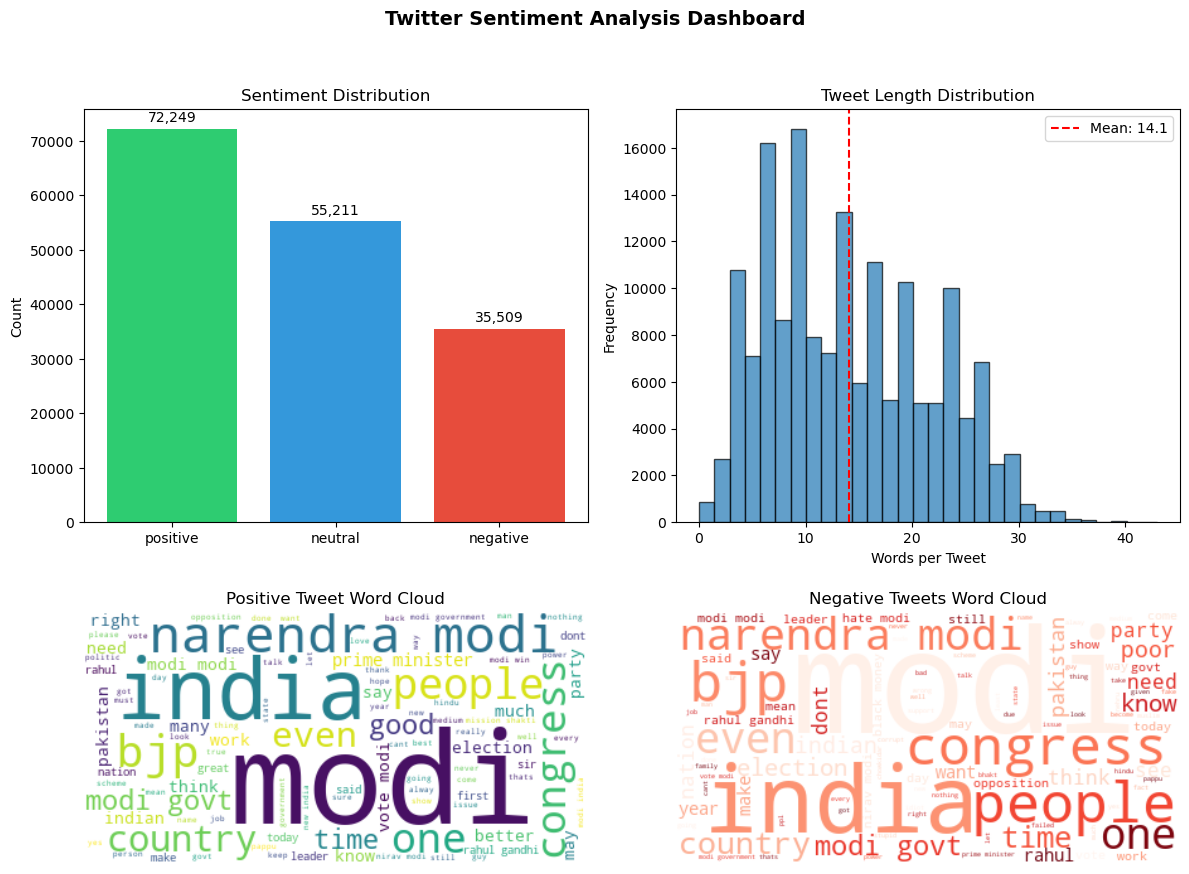


 TOP 10 MOST COMMON WORDS:
 'modi': 155,680
 'india': 31,040
 'bjp': 14,702
 'people': 14,423
 'like': 12,946
 'congress': 12,939
 'election': 11,721
 'narendra': 11,471
 'vote': 10,940
 'govt': 10,035
Successful!


In [7]:
print("\n" + "=" * 60)
print("EXPLORATORY DATA ANALYSIS MODULE")
print("=" * 60)

class DataAnalyzer:
    def __init__(self):
        self.sentiment_colors = {
            'positive': '#2ecc71',
            'negative': '#e74c3c',
            'neutral': '#3498db'
        }

    def show_summary(self, df):
        """Display data summary"""
        print("\n" + "=" * 60)
        print("DATA SUMMARY")
        print("=" * 60)

        print(f"Total Tweets: {len(df):,}")

        # sentiment distribution
        sentiment_counts = df['sentiment'].value_counts()
        for sentiment, count in sentiment_counts.items():
            percentage = (count / len(df)) * 100
            print(f"{str(sentiment).capitalize():8s}: {count:6,d} ({percentage:.1f}%)")

        # Tweet length stats
        avg_length = df['tweet_length'].mean()
        print(f"\nAverage tweet length: {avg_length:.1f} words")

    def create_visualizations(self, df):
        """Create main visualizations"""
        # Ensure we have data to plot
        if df.empty:
            print("No data available to visualize.")
            return

        fig, axes = plt.subplots(2, 2, figsize=(12, 10))

        # 1. Sentiment Distribution
        sentiment_counts = df['sentiment'].value_counts()
        colors = [self.sentiment_colors.get(s, '#7f8c8d') for s in sentiment_counts.index]

        axes[0,0].bar(sentiment_counts.index, sentiment_counts.values, color=colors)
        axes[0,0].set_title('Sentiment Distribution')
        axes[0,0].set_ylabel('Count')

        # Add counts on bars
        for i, count in enumerate(sentiment_counts.values):
            axes[0,0].text(i, count + max(sentiment_counts.values)*0.01,
                           f"{count:,}", ha='center', va='bottom')

        # 2. Tweet Length Distribution
        axes[0,1].hist(df['tweet_length'], bins=30, edgecolor='black', alpha=0.7)
        axes[0,1].axvline(df['tweet_length'].mean(), color='red', linestyle='--',
                        label=f'Mean: {df["tweet_length"].mean():.1f}')
        axes[0,1].set_title('Tweet Length Distribution')
        axes[0,1].set_xlabel('Words per Tweet')
        axes[0,1].set_ylabel('Frequency')
        axes[0,1].legend()

        # 3. Word Cloud (Positive)
        positive_text = ' '.join(df[df['sentiment'] == 'positive']['processed_text'].astype(str))
        if positive_text.strip():
            wordcloud = WordCloud(width=400, height=200, background_color='white',
                                  max_words=100).generate(positive_text)
            axes[1,0].imshow(wordcloud, interpolation='bilinear')
            axes[1,0].set_title('Positive Tweet Word Cloud')
        axes[1,0].axis('off')

        # 4. Word Cloud (Negative)
        negative_text = ' '.join(df[df['sentiment'] == 'negative']['processed_text'].astype(str))
        if negative_text.strip():
            wordcloud = WordCloud(width=400, height=200, background_color='white',
                                  max_words=100, colormap='Reds').generate(negative_text)
            axes[1,1].imshow(wordcloud, interpolation='bilinear')
            axes[1,1].set_title('Negative Tweets Word Cloud')
        axes[1,1].axis('off')

        plt.suptitle('Twitter Sentiment Analysis Dashboard', fontsize=14, fontweight='bold')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

        # Show most common words
        self.show_common_words(df)

    def show_common_words(self, df):
        """Display most common words"""
        all_words = ' '.join(df['processed_text'].astype(str)).split()
        common_words = Counter(all_words).most_common(10)

        print("\n TOP 10 MOST COMMON WORDS:")
        for word, count in common_words:
            print(f" '{word}': {count:,}")

# --- EXECUTION LINE ---
analyzer = DataAnalyzer()
analyzer.show_summary(df)
analyzer.create_visualizations(df)

print("Successful!")


MACHINE LEARNING MODEL MODULE

 Data Split:
 Training: 130,375 tweets
 Testing: 32,594 tweets

 Training model...
Model trained successfully!

 MODEL EVALUATION:
 Accuracy: 81.28%

 Classification Report:
              precision    recall  f1-score   support

    negative       0.82      0.65      0.73      7102
     neutral       0.76      0.92      0.84     11042
    positive       0.86      0.81      0.83     14450

    accuracy                           0.81     32594
   macro avg       0.81      0.79      0.80     32594
weighted avg       0.82      0.81      0.81     32594



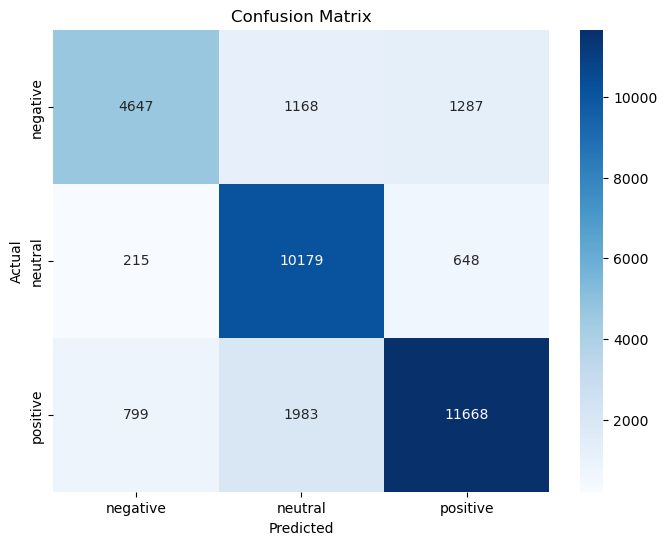

Successful!


In [9]:
print("\n" + "=" * 60)
print("MACHINE LEARNING MODEL MODULE")
print("=" * 60)

class SentimentModel:
    def __init__(self):
        self.vectorizer = TfidfVectorizer(
            max_features = 3000,
            ngram_range = (1, 2),
            min_df = 5,
            max_df = 0.8,
            stop_words = 'english'
        )
        self.model = RandomForestClassifier(n_estimators = 100, random_state = 42)
        self.label_encoder = LabelEncoder()

    def prepare_data(self, df):
        """Prepare data for training"""
        # Ensure we don't have NaNs in the text
        X = df['processed_text'].fillna('')
        y = df['sentiment']

        # Encode labels (e.g., 'positive' -> 2, 'negative' -> 0)
        y_encoded = self.label_encoder.fit_transform(y)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, test_size = 0.2, random_state=42, stratify=y_encoded
        )

        print(f"\n Data Split:")
        print(f" Training: {len(X_train):,} tweets")
        print(f" Testing: {len(X_test):,} tweets")

        return X_train, X_test, y_train, y_test 

    def train(self, X_train, y_train):
        """Train the model"""
        print("\n Training model...")

        # Vectorize text - Learn the vocabulary and transform to numbers
        X_train_vec = self.vectorizer.fit_transform(X_train)

        # Train model
        self.model.fit(X_train_vec, y_train)

        print("Model trained successfully!")
        return self.model

    def evaluate(self, X_test, y_test):
        """Evaluate model performance"""
        
        X_test_vec = self.vectorizer.transform(X_test)
        y_pred = self.model.predict(X_test_vec)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)

        print("\n MODEL EVALUATION:")
        print(f" Accuracy: {accuracy:.2%}") # FIXED: Typo
        print(f"\n Classification Report:")
        print(classification_report(y_test, y_pred,
                                    target_names = self.label_encoder.classes_))

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.label_encoder.classes_,
                    yticklabels=self.label_encoder.classes_) # FIXED: Typo
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        return accuracy

# --- EXECUTION LINE ---
sentiment_model = SentimentModel()
X_train, X_test, y_train, y_test = sentiment_model.prepare_data(df)
sentiment_model.train(X_train, y_train)
accuracy = sentiment_model.evaluate(X_test, y_test)

print("Successful!")

In [18]:

print("\n" + "=" * 60)
print("DEPLOYMENT MODULE (PREDICTION API)")
print("=" * 60)

class SentimentPredictor:
    def __init__(self, vectorizer, model, label_encoder):
        self.vectorizer = vectorizer
        self.model = model
        self.label_encoder = label_encoder
        # We use the class we created earlier for consistent cleaning
        self.preprocessor = TextPreprocessor()

    def predict(self, text):
        """Predict sentiment for a single text"""
        # 1. Preprocess using the exact same logic as training
        cleaned_text = self.preprocessor.clean_text(text)

        # 2. Vectorize transform
        text_vec = self.vectorizer.transform([cleaned_text])

        # 3. Predict the numerical label
        prediction = self.model.predict(text_vec)[0]
        
        # 4. Convert numerical label back to text (e.g., 2 -> 'positive')
        sentiment = self.label_encoder.inverse_transform([prediction])[0]

        # 5. Get probability/confidence
        if hasattr(self.model, 'predict_proba'):
            proba = self.model.predict_proba(text_vec)[0]
            confidence = max(proba)
        else:
            confidence = 1.0

        return { 
            'text': text[:100] + '...' if len(text) > 100 else text,
            'sentiment': sentiment,
            'confidence': float(confidence),
            'timestamp': datetime.now().isoformat() # FIXED: 'mow' -> 'now'
        }

    def batch_predict(self, texts):
        """Predict sentiment for multiple texts"""
        return [self.predict(text) for text in texts]

# --- EXECUTION LINE ---
# Initialize the predictor using the parts of the model we just trained
predictor = SentimentPredictor(
    sentiment_model.vectorizer, 
    sentiment_model.model, 
    sentiment_model.label_encoder
)

# Test a single tweet
test_tweet = "I absolutely love how this project is coming together!"
result = predictor.predict(test_tweet)

print(f"\nTest Result:")
print(f"Text: {result['text']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Confidence: {result['confidence']:.2%}")

print("\nSuccessful!")


DEPLOYMENT MODULE (PREDICTION API)

Test Result:
Text: I absolutely love how this project is coming together!
Sentiment: positive
Confidence: 96.00%

Successful!



 MAIN PIPELINE - PUTTING IT ALL TOGETHER
TWITTER SENTIMENT ANALYSIS PIPELINE
Attempting to load: Twitter_Data.csv...
Success! Data loaded: 162969 tweets
Preprocessing text...

DATA SUMMARY
Total Tweets: 162,969
Positive: 72,249 (44.3%)
Neutral : 55,211 (33.9%)
Negative: 35,509 (21.8%)

Average tweet length: 14.1 words


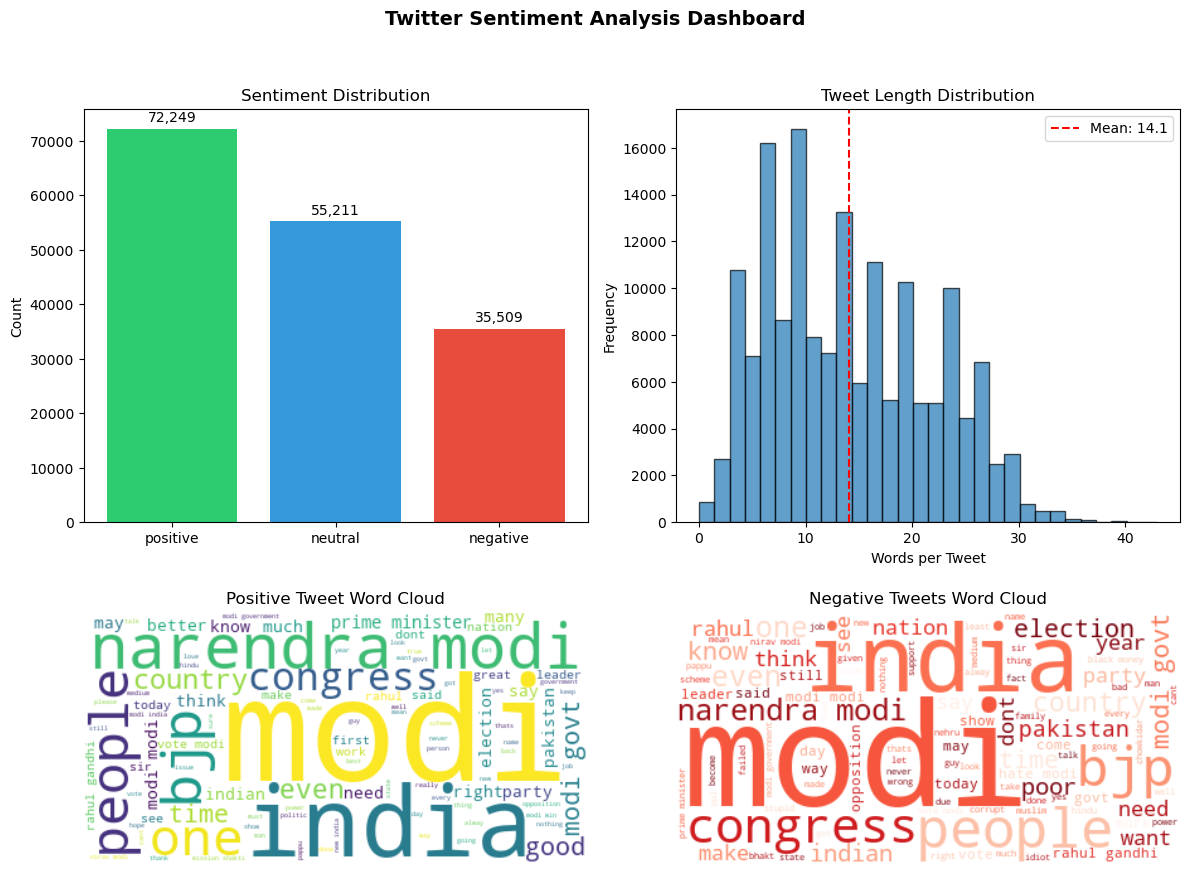


 TOP 10 MOST COMMON WORDS:
 'modi': 155,680
 'india': 31,040
 'bjp': 14,702
 'people': 14,423
 'like': 12,946
 'congress': 12,939
 'election': 11,721
 'narendra': 11,471
 'vote': 10,940
 'govt': 10,035

 Data Split:
 Training: 130,375 tweets
 Testing: 32,594 tweets

 Training model...
Model trained successfully!

 MODEL EVALUATION:
 Accuracy: 81.28%

 Classification Report:
              precision    recall  f1-score   support

    negative       0.82      0.65      0.73      7102
     neutral       0.76      0.92      0.84     11042
    positive       0.86      0.81      0.83     14450

    accuracy                           0.81     32594
   macro avg       0.81      0.79      0.80     32594
weighted avg       0.82      0.81      0.81     32594



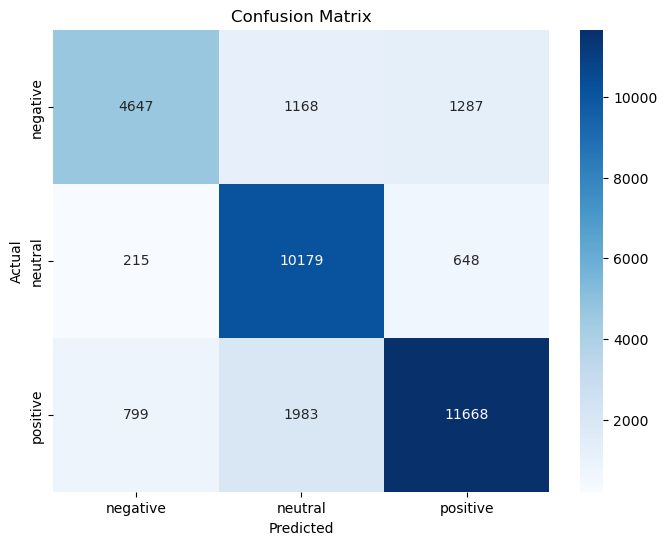


 SAVING MODEL FOR DEPLOYMENT...
Model saved as 'sentiment_model.pkl'
Sample predictions saved as 'Sample_predictions.json'

 FINAL REPORT:
----------------------------------------
Total Tweets Analyzed: 162,969
Model Accuracy: 81.28%
Positive: 72,249 (44.3%)
Neutral: 55,211 (33.9%)
Negative: 35,509 (21.8%)

 PIPELINE COMPLETED SUCCESSFULLY!


In [13]:
print("\n" + "=" * 60)
print(" MAIN PIPELINE - PUTTING IT ALL TOGETHER")
print("=" * 60)

def run_complete_pipeline():
    """Main function to run the complete analysis"""
    print("TWITTER SENTIMENT ANALYSIS PIPELINE")
    print("=" * 60)

    # 1. Load Data
    loader = DataLoader('Twitter_Data.csv')
    df = loader.load_data()

    if df is None:
        print("Failed to load data. Exiting...")
        return

    # 2. Preprocess Text
    preprocessor = TextPreprocessor() # Fixed spelling
    df = preprocessor.process_dataframe(df)

    # 3. Analyze Data
    analyzer = DataAnalyzer()
    analyzer.show_summary(df)
    analyzer.create_visualizations(df)

    # 4. Train model
    sentiment_model = SentimentModel()
    X_train, X_test, y_train, y_test = sentiment_model.prepare_data(df)
    sentiment_model.train(X_train, y_train)
    
    # evaluate
    accuracy = sentiment_model.evaluate(X_test, y_test)

    # 5. Create Predictor
    predictor = SentimentPredictor(
            sentiment_model.vectorizer,
            sentiment_model.model,
            sentiment_model.label_encoder
    )

    # 6. Save Model for Deployment
    print("\n SAVING MODEL FOR DEPLOYMENT...")

    model_data = {
        'vectorizer': sentiment_model.vectorizer,
        'model': sentiment_model.model,
        'label_encoder': sentiment_model.label_encoder, # FIXED: logic error
        'timestamp': datetime.now().isoformat()
    }

    joblib.dump(model_data, 'sentiment_model.pkl')
    print("Model saved as 'sentiment_model.pkl'")

    # 7. Save Sample predictions
    test_tweets = [
        "This is amazing! I love this product!",
        "Very disappointed with the service.",
        "It's okay, nothing special.",
        "Worst experience ever!",
        "Great job, keep it up!"
    ]
    predictions = predictor.batch_predict(test_tweets)
    
    
    with open('Sample_predictions.json', 'w') as f:
        json.dump(predictions, f, indent=2)

    print("Sample predictions saved as 'Sample_predictions.json'")

    # 8. Final Report
    generate_final_report(df, accuracy)

    print("\n" + "=" * 60)
    print(" PIPELINE COMPLETED SUCCESSFULLY!")
    print("=" * 60)
    return predictor

def generate_final_report(df, accuracy):
    """Generate final analysis report"""
    report = { 
        'timestamp': datetime.now().isoformat(),
        'total_tweets': len(df),
        'sentiment_distribution': df['sentiment'].value_counts().to_dict(),
        'average_tweet_length': float(df['tweet_length'].mean()),
        'model_accuracy': float(accuracy),
        'top_words': dict(Counter(' '.join(df['processed_text']).split()).most_common(10))
    }

    
    with open('analysis_report.json', 'w') as f:
        json.dump(report, f, indent=2)

    print("\n FINAL REPORT:")
    print("-" * 40)
    print(f"Total Tweets Analyzed: {report['total_tweets']:,}")
    print(f"Model Accuracy: {report['model_accuracy']:.2%}")

    for sentiment, count in report['sentiment_distribution'].items():
        percentage = (count / report['total_tweets']) * 100
        print(f"{str(sentiment).capitalize()}: {count:,} ({percentage:.1f}%)")


predictor = run_complete_pipeline()

In [15]:

print("\n" + "=" * 60)
print(" DEPLOYMENT READY FUNCTIONS")
print("=" * 60)

def load_trained_model(model_path='sentiment_model.pkl'):
    """Load a previously trained model"""
    try:
        model_data = joblib.load(model_path)
        print(f" Model loaded from {model_path}")
        # Note: Ensure 'accuracy' was saved in your model_data dict!
        print(f" Accuracy: {model_data.get('accuracy', 0):.2%}")
        print(f" Saved: {model_data['timestamp']}")

        predictor = SentimentPredictor(
            model_data['vectorizer'],
            model_data['model'],
            model_data['label_encoder']
        )

        return predictor
    except Exception as e:
        print(f" Error loading model: {e}")
        return None

def analyze_new_tweet(tweet_text, model_path='sentiment_model.pkl'):
    """Quick function to analyze a new tweet"""
    predictor = load_trained_model(model_path)

    if predictor:
        result = predictor.predict(tweet_text)
        print(f"\n ANALYSIS RESULT:")
        print(f"Tweet: {result['text']}")
        print(f"Sentiment: {result['sentiment'].upper()}")
        print(f"Confidence: {result['confidence']:.2%}")
        return result
    return None

def real_time_analysis():
    """Interactive real-time sentiment analysis"""
    print("\n REAL-TIME SENTIMENT ANALYSIS")
    print("Type 'quit' to exit")
    print("-" * 40)

    predictor = load_trained_model()

    if not predictor:
        print("No model found. Please run training first.")
        return

    while True:
        tweet = input("\nEnter tweet to analyze (or 'quit' to exit): ")

        # 1. Check for exit - FIXED: Added break
        if tweet.lower() in ['quit', 'exit', 'q']:
            print("Goodbye!")
            break

        # 2. Process non-empty strings
        if tweet.strip():
            result = predictor.predict(tweet)

            # Color code the sentiment - FIXED: Indentation and logic
            sentiment = result['sentiment']
            if sentiment == 'positive':
                color = '\033[92m' # Green
            elif sentiment == 'negative':
                color = '\033[91m' # Red
            else:
                color = '\033[94m' # Blue

            print(f"Result: {color}{sentiment.upper()}\033[0m")
            print(f"Confidence: {result['confidence']:.2%}")
            print(f"Timestamp: {result['timestamp']}")

# --- EXECUTION ---
# You can now call real_time_analysis() to start the interactive loop.
print("SUCCESSFUL!")


 DEPLOYMENT READY FUNCTIONS
SUCCESSFUL!



 QUICK SENTIMENT ANALYSIS
Attempting to load: Twitter_Data.csv...
Success! Data loaded: 162969 tweets
Preprocessing text...

DATA SUMMARY
Total Tweets: 162,969
Positive: 72,249 (44.3%)
Neutral : 55,211 (33.9%)
Negative: 35,509 (21.8%)

Average tweet length: 14.1 words

 Data Split:
 Training: 130,375 tweets
 Testing: 32,594 tweets

 Training model...
Model trained successfully!

 MODEL EVALUATION:
 Accuracy: 81.28%

 Classification Report:
              precision    recall  f1-score   support

    negative       0.82      0.65      0.73      7102
     neutral       0.76      0.92      0.84     11042
    positive       0.86      0.81      0.83     14450

    accuracy                           0.81     32594
   macro avg       0.81      0.79      0.80     32594
weighted avg       0.82      0.81      0.81     32594



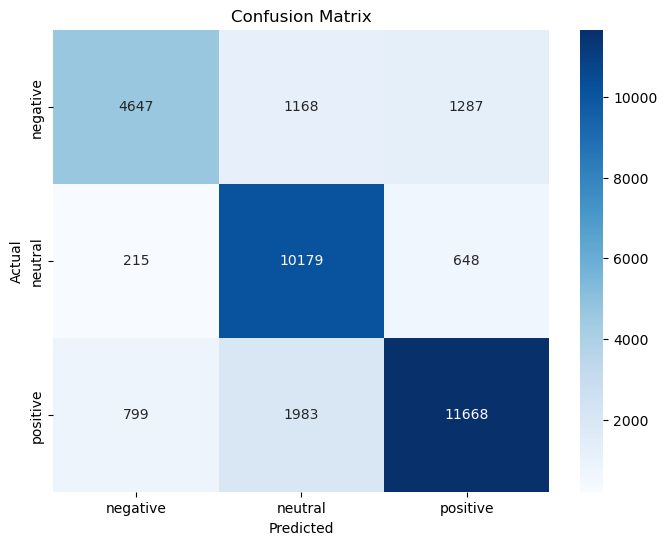


 Quick analysis complete! Model Accuracy: 81.28%


In [17]:
def quick_analysis():
    """Run a quick analysis without all visualizations"""
    print("\n" + "=" * 40)
    print(" QUICK SENTIMENT ANALYSIS")
    print("=" * 40)

    # 1. Load Data
    loader = DataLoader('Twitter_Data.csv')
    df = loader.load_data()

    if df is not None:
        # 2. Preprocess
        preprocessor = TextPreprocessor()
        df = preprocessor.process_dataframe(df)

        # 3. Show quick text summary (No charts)
        analyzer = DataAnalyzer()
        analyzer.show_summary(df)

        # 4. Train model
        model = SentimentModel()
        X_train, X_test, y_train, y_test = model.prepare_data(df)
        model.train(X_train, y_train)
        accuracy = model.evaluate(X_test, y_test)

        print(f"\n Quick analysis complete! Model Accuracy: {accuracy:.2%}")
        return model
    else:
        print("Error: Could not load data.")
        return None

# --- EXECUTION ---
trained_model = quick_analysis()

### ==> MAIN EXECUTION -> CHOOSE YOUR OPTION

In [21]:

if __name__ == "__main__":
    print("="*60)
    print("TWITTER SENTIMENT ANALYSIS SYSTEM")
    print("="*60)
    print("\nChoose an option:")
    print("1. Run Complete Analysis Pipeline")
    print("2. Quick Analysis (Fast)")
    print("3. Real-time tweet Analysis")
    print("4. Analyze a Single Tweet")
    print("5. Load Existing Model")
    print("0. Exit")

    choice = input("\nEnter your choice (1-5): ")

    if choice == '1':
        # Run complete pipeline
        predictor = run_complete_pipeline()

    elif choice == '2':
        # Quick analysis
        model = quick_analysis()

    elif choice == '3':
        # Real-time analysis
        real_time_analysis()

    elif choice == '4':
        # Analyzer single tweet
        tweet = input("\nEnter tweet to analyze: ")
        if tweet.strip():
            result = analyzer_new_tweet(tweet)

    elif choice == '5':
        # load existing model
        predictor = load_trained_model()
        if predictor:
            print("\n Model load successful!")
            print("Use predictor.predict('your text') to analyze tweets")

    elif choice == '0':
        print("Goodbye!")

    else:
        print("Invalid choice. Please run the script again.")

    
        

TWITTER SENTIMENT ANALYSIS SYSTEM

Choose an option:
1. Run Complete Analysis Pipeline
2. Quick Analysis (Fast)
3. Real-time tweet Analysis
4. Analyze a Single Tweet
5. Load Existing Model
0. Exit



Enter your choice (1-5):  0


Goodbye!
